# Analiza czynników mogących wpływać na prawdopodobieństwo powrotu użytkownika na stronę

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
import scipy.stats as ss
%matplotlib inline

Załadowanie zbioru danych i oczyszczenie z niepotrzebnych znaków

In [2]:
loc = "dane.csv"
df = pd.read_csv(loc, header=0, sep="[;]", engine="python", 
                 names=("client_id","action_time", "pagePath", "medium", "eventAction", "date"))
df.client_id = df.client_id.str[1:]
df.date = df.date.str[:-1]
df.head()

,client_id,action_time,pagePath,medium,eventAction,date
0,d0a213b0718cd0e10475ce11d893c3cc,2020-07-29T15:38:27Z,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,pageview,29.07.2020
1,4416f6ec763cc9e65ca17482d3960971,2020-07-29T21:03:06Z,/,(none),pageview,29.07.2020
2,c3d6e02ad3e2a781dba7c48a4d354199,2020-07-29T07:51:28Z,/o-portalu,banner,pageview,29.07.2020
3,3bd4feb129163c7889a70d3d12c6e82d,2020-07-29T12:23:00Z,"/lekcja/geografia,12901cca29551ad7d556962231a1...",organic,pageview,29.07.2020
4,3d90c06c313a2120ce98ff14b6581570,2020-07-29T12:27:30Z,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",organic,pageview,29.07.2020


Opis zmiennych:<br />&nbsp;&nbsp;&nbsp;
    client_id - ID użytkownika (pozyskiwane za pomocą cookie)<br />&nbsp;&nbsp;&nbsp;
    ts - dokładny czas, w którym nastąpiło wydarzenie<br />&nbsp;&nbsp;&nbsp;
    pagePath - ścieżka strony, która była oglądana<br />&nbsp;&nbsp;&nbsp;
    medium - czyli medium, z którego użytkownik przyszedł na stronę <br />&nbsp;&nbsp;&nbsp;
    eventAction - rodzaj akcji wykonanej przez użytkownika<br />&nbsp;&nbsp;&nbsp;
    date - data zdarzenia<br />&nbsp;&nbsp;&nbsp;
    <br />
Opis mediów kolumny "medium":<br />&nbsp;&nbsp;&nbsp;
    cpc - wejście z kampanii marketingowej<br />&nbsp;&nbsp;&nbsp;
    organic - wejście z wyszukiwarki<br />&nbsp;&nbsp;&nbsp;
    banner - wejście z baneru reklamowego<br />&nbsp;&nbsp;&nbsp;
    referral - wejście z linku polecającego<br />&nbsp;&nbsp;&nbsp;
    email - wejście przez mail<br />&nbsp;&nbsp;&nbsp;
    post - wejście przez post<br />&nbsp;&nbsp;&nbsp;
    link - wejście przez link<br />&nbsp;&nbsp;&nbsp;
    webpush - wejście przez wiadomości, wysyłane przez stronę internetową<br />&nbsp;&nbsp;&nbsp;

Konwersja kolumny "date" na *datetime* i utworzenie kolumny "time" z czasem zdarzenia

In [3]:
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df["time"] = pd.to_datetime(df["action_time"]).dt.time
df.drop(["action_time"], axis="columns", inplace=True)
df.head()

,client_id,pagePath,medium,eventAction,date,time
0,d0a213b0718cd0e10475ce11d893c3cc,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,pageview,2020-07-29,15:38:27
1,4416f6ec763cc9e65ca17482d3960971,/,(none),pageview,2020-07-29,21:03:06
2,c3d6e02ad3e2a781dba7c48a4d354199,/o-portalu,banner,pageview,2020-07-29,07:51:28
3,3bd4feb129163c7889a70d3d12c6e82d,"/lekcja/geografia,12901cca29551ad7d556962231a1...",organic,pageview,2020-07-29,12:23:00
4,3d90c06c313a2120ce98ff14b6581570,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",organic,pageview,2020-07-29,12:27:30


Dane nie zawierają wartości pustych, nie wymagają więc oczyszczenia z nich.

In [4]:
print(df.isnull().values.sum())

0


Zmiana typu danych kolumny "medium" na typ danych *category*

In [5]:
df["medium"] = df["medium"].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466822 entries, 0 to 466821
Data columns (total 6 columns):
client_id      466822 non-null object
pagePath       466822 non-null object
medium         466822 non-null category
eventAction    466822 non-null object
date           466822 non-null datetime64[ns]
time           466822 non-null object
dtypes: category(1), datetime64[ns](1), object(4)
memory usage: 18.3+ MB


Kolumna "eventAction" zostaje usunięta z powodu występowania tylko jednej zmiennej.

In [7]:
df.eventAction.describe()

count       466822
unique           1
top       pageview
freq        466822
Name: eventAction, dtype: object

In [8]:
df.drop(["eventAction"], axis="columns", inplace=True)

In [9]:
df.describe()

,client_id,pagePath,medium,date,time
count,466822,466822,466822,466822,466822
unique,230193,2549,10,37,70553
top,64e4c7ca28927cfd62a503e100afe752,/,organic,2020-08-21 00:00:00,10:08:41
freq,855,67224,260306,25938,26
first,NaN,NaN,NaN,2020-07-29 00:00:00,NaN
last,NaN,NaN,NaN,2020-10-09 00:00:00,NaN


In [10]:
df.describe(include=np.object)

,client_id,pagePath,time
count,466822,466822,466822
unique,230193,2549,70553
top,64e4c7ca28927cfd62a503e100afe752,/,10:08:41
freq,855,67224,26


Podliczenie wystąpień każdego z mediów, z którego użytkownik mógł wejść na stronę.

In [11]:
df["medium"].value_counts()

organic      260306
(none)        67090
cpc           50864
banner        46942
referral      30169
email         11243
post            102
link             74
webpush          31
(not set)         1
Name: medium, dtype: int64

Posortowanie zbioru według kolumny "medium"

In [12]:
df["medium_count"] = df.groupby("medium")["medium"].transform("count")
df = df.sort_values("medium_count", ascending=False)
df = df.drop("medium_count", axis = 1)

In [13]:
df

,client_id,pagePath,medium,date,time
0,d0a213b0718cd0e10475ce11d893c3cc,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,2020-07-29,15:38:27
270140,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",organic,2020-08-14,13:04:50
270138,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",organic,2020-08-14,12:53:40
270137,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",organic,2020-08-14,12:27:48
270135,fedd128691499104578f0d8fa4a11fa4,"/lekcja/biologia,c4a61b24e0a70445a593ed3167d7c6eb",organic,2020-08-14,07:37:40
...,...,...,...,...,...
346272,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-08-17,16:24:38
5336,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-07-29,19:44:39
75595,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-08-02,14:51:03
36471,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-07-31,21:15:53


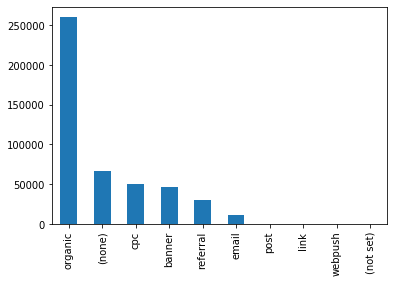

In [14]:
df["medium"].value_counts().plot(kind="bar")

Stworzenie kolumny "pageMainCat" z kategoriami występującymi w kolumnie "pagePath". Ścieżki nie przypisane do żadnej z kategorii, otrzymują etykietę "Others"

In [15]:
df["pageMainCat"] = df["pagePath"]

In [16]:
main_categories = {
    "/lekcja/": "lekcja", 
    "/kategorie/": "kategorie",
    "/fiszki-i-quizy/": "fiszki-i-quizy",
    "/sprawdz-sie/": "sprawdz-sie",    
    "/quiz/": "quiz",
    "/fiszki/": "fiszki",
    "/szukaj/": "szukaj",
    "lesson/preview": "lesson/preview",
    "/o-portalu": "o-portalu",
}
    
for key, value in main_categories.items():
    df["pageMainCat"] = df["pageMainCat"].astype(str).apply(lambda X:  value if key in X else X) 
    
owi_set = set(main_categories.values())
df["pageMainCat"] = df["pageMainCat"].apply(lambda x: x if x in owi_set else "Others")  

In [17]:
df["pageMainCat"] = df["pageMainCat"].astype("category")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466822 entries, 0 to 10918
Data columns (total 6 columns):
client_id      466822 non-null object
pagePath       466822 non-null object
medium         466822 non-null category
date           466822 non-null datetime64[ns]
time           466822 non-null object
pageMainCat    466822 non-null category
dtypes: category(2), datetime64[ns](1), object(3)
memory usage: 18.7+ MB


In [19]:
df

,client_id,pagePath,medium,date,time,pageMainCat
0,d0a213b0718cd0e10475ce11d893c3cc,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,2020-07-29,15:38:27,lekcja
270140,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",organic,2020-08-14,13:04:50,lekcja
270138,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",organic,2020-08-14,12:53:40,lekcja
270137,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",organic,2020-08-14,12:27:48,lekcja
270135,fedd128691499104578f0d8fa4a11fa4,"/lekcja/biologia,c4a61b24e0a70445a593ed3167d7c6eb",organic,2020-08-14,07:37:40,lekcja
...,...,...,...,...,...,...
346272,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-08-17,16:24:38,Others
5336,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-07-29,19:44:39,Others
75595,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-08-02,14:51:03,Others
36471,f5402b2f66d5f1e952a7baa393dd7e0c,/,webpush,2020-07-31,21:15:53,Others


Ilustracja częstości występowania danej głównej kategorii z kolumny "pageMainCat".

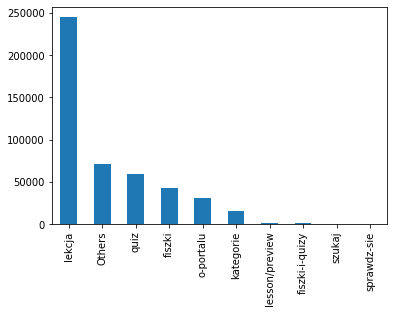

In [20]:
df["pageMainCat"].value_counts().plot(kind="bar")

Kodowanie kolumny "medium", gdzie "organic" przyjmuje wartość jeden, a pozostałe rodzje przyjmują wartość zero.

In [21]:
df_specific = df.copy()
df_specific["Organic_code"] = np.where(df_specific["medium"].str.contains("organic"), 1, 0)
df_specific = df_specific.drop("medium", axis = 1)

df_specific.head()

,client_id,pagePath,date,time,pageMainCat,Organic_code
0,d0a213b0718cd0e10475ce11d893c3cc,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,15:38:27,lekcja,1
270140,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,13:04:50,lekcja,1
270138,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,12:53:40,lekcja,1
270137,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,12:27:48,lekcja,1
270135,fedd128691499104578f0d8fa4a11fa4,"/lekcja/biologia,c4a61b24e0a70445a593ed3167d7c6eb",2020-08-14,07:37:40,lekcja,1


Kodowanie zmiennych "pageMainCat" za pomocą metody *Target/Guided Encoding*.

Obliczenie prawdopodobieństwa każdej z głównych kategorii na podstawie wartości celu kolumny "Organic_code".

In [22]:
df_specific.groupby(["pageMainCat"])["Organic_code"].mean()

pageMainCat
Others            0.140407
fiszki            0.285261
fiszki-i-quizy    0.758673
kategorie         0.371252
lekcja            0.858868
lesson/preview    0.239291
o-portalu         0.002661
quiz              0.351063
sprawdz-sie       0.640625
szukaj            0.307554
Name: Organic_code, dtype: float64

Największe prawdopodobieństwo, że użytkownik wchodzący na stronę przez wyszukiwarkę (organic) występuje dla lekcji - ok. 86%.

In [23]:
Encoded_Lables = df_specific.groupby(["pageMainCat"])["Organic_code"].mean().sort_values().index

Stworzenie słowników zawierających klucz jako nazwę głównej kategorii i wartościami jako wspólny ranking prawdopodobieństwa.

In [24]:
Encoded_Lables_Ranks = { k:i for i, k in enumerate(Encoded_Lables, 0) }

Stworzenie nowej kolumny "pageMainCat_Encoded" i zmapowanie wartośći głównych kategorii z rankingiem wspólnego prawdopodobieństwa.

In [25]:
df_specific["pageMainCat_Encoded"] = df_specific["pageMainCat"].map(Encoded_Lables_Ranks)

Usunięcie oryginalnej kolumny "pageMainCat".

In [26]:
#df_specific = df_specific.drop("pageMainCat", axis = 1)

In [27]:
df_specific

,client_id,pagePath,date,time,pageMainCat,Organic_code,pageMainCat_Encoded
0,d0a213b0718cd0e10475ce11d893c3cc,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,15:38:27,lekcja,1,9
270140,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,13:04:50,lekcja,1,9
270138,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,12:53:40,lekcja,1,9
270137,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,12:27:48,lekcja,1,9
270135,fedd128691499104578f0d8fa4a11fa4,"/lekcja/biologia,c4a61b24e0a70445a593ed3167d7c6eb",2020-08-14,07:37:40,lekcja,1,9
...,...,...,...,...,...,...,...
346272,f5402b2f66d5f1e952a7baa393dd7e0c,/,2020-08-17,16:24:38,Others,0,1
5336,f5402b2f66d5f1e952a7baa393dd7e0c,/,2020-07-29,19:44:39,Others,0,1
75595,f5402b2f66d5f1e952a7baa393dd7e0c,/,2020-08-02,14:51:03,Others,0,1
36471,f5402b2f66d5f1e952a7baa393dd7e0c,/,2020-07-31,21:15:53,Others,0,1


Obliczenie Współczynnika V Craméra pomiędzy kolumnami "Organic_code" i "pageMainCat_Encoded".

In [28]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [29]:
confusion_matrix = pd.crosstab(df_specific["Organic_code"], df_specific["pageMainCat_Encoded"]).as_matrix()
cramers_v(confusion_matrix)

C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


0.6621484147835431

Zachodzi silna korelacja pomiędzy wejściem na stronę przez wyszukiwarkę (organic), a głównymi kategoriami, na które wchodzą używtkownicy.

Kodowanie zmiennych "pageMainCat" za pomocą metody *One Hot Encoding*.

In [30]:
df_onehot = df_specific.copy()
df_onehot = pd.get_dummies(df_onehot, columns=["pageMainCat"], prefix = ["pageMainCat"])

df_onehot.head()

,client_id,pagePath,date,time,Organic_code,pageMainCat_Encoded,pageMainCat_Others,pageMainCat_fiszki,pageMainCat_fiszki-i-quizy,pageMainCat_kategorie,pageMainCat_lekcja,pageMainCat_lesson/preview,pageMainCat_o-portalu,pageMainCat_quiz,pageMainCat_sprawdz-sie,pageMainCat_szukaj
0,d0a213b0718cd0e10475ce11d893c3cc,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,15:38:27,1,9,0,0,0,0,1,0,0,0,0,0
270140,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,13:04:50,1,9,0,0,0,0,1,0,0,0,0,0
270138,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,12:53:40,1,9,0,0,0,0,1,0,0,0,0,0
270137,49a83884edb7b3f4efc8996a8436ac68,"/lekcja/jezyk-polski,fb9155ca2e6627846b9b2ffea...",2020-08-14,12:27:48,1,9,0,0,0,0,1,0,0,0,0,0
270135,fedd128691499104578f0d8fa4a11fa4,"/lekcja/biologia,c4a61b24e0a70445a593ed3167d7c6eb",2020-08-14,07:37:40,1,9,0,0,0,0,1,0,0,0,0,0


In [46]:
cm_Others = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_Others"]).as_matrix()
cm_fiszki = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_fiszki"]).as_matrix()
cm_fiszki_i_quizy = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_fiszki-i-quizy"]).as_matrix()
cm_kategorie = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_kategorie"]).as_matrix()
cm_lekcja = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_lekcja"]).as_matrix()
cm_lesson_preview = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_lesson/preview"]).as_matrix()
cm_o_portalu = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_o-portalu"]).as_matrix()
cm_quiz = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_quiz"]).as_matrix()
cm_sprawdz_sie = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_sprawdz-sie"]).as_matrix()
cm_szukaj = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_szukaj"]).as_matrix()

C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_l

In [47]:
data = {'Kategoria':  ['lekcja', 'Others','fiszki','quiz','kategorie', 'lesson_preview', 'fiszki_i_quizy', 'szukaj', 'sprawdz_sie'],
        'Współczynnik V Craméra': [cramers_v(cm_lekcja), cramers_v(cm_Others) ,cramers_v(cm_fiszki), cramers_v(cm_quiz),
                                   cramers_v(cm_kategorie), cramers_v(cm_lesson_preview), cramers_v(cm_fiszki_i_quizy),
                                  cramers_v(cm_szukaj), cramers_v(cm_sprawdz_sie)]
        }

Cramér = pd.DataFrame (data, columns = ['Kategoria','Współczynnik V Craméra'])

Cramér

,Kategoria,Współczynnik V Craméra
0,lekcja,0.637651
1,Others,0.355948
2,fiszki,0.174430
3,quiz,0.159084
4,kategorie,0.069299
5,lesson_preview,0.024324
6,fiszki_i_quizy,0.015139
7,szukaj,0.017261
8,sprawdz_sie,0.001001


Po sprawdzeniu Współczynnika korelacji V Cramera, można określić, że z pośród rozpatrywanych kategorii, jedynie "lekcja" wykazuje realną korelację z wejściem na stronę przez wyszukiwarkę (organic). 